In [41]:
%reset -f

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [43]:
import scipy.stats

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [45]:
import sklearn.preprocessing
import sklearn.model_selection

In [46]:
import uproot
uproot.default_library = "np"

In [47]:
import os.path

In [48]:
import logging
logging.basicConfig(level=logging.INFO)

In [49]:
np.set_printoptions(precision=4, suppress=True)

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data

In [51]:
raw_names = [
    "data/sim09g_Kee_2017MD_folded.root:DecayTree;1",
    #"data/sim09g_Kmumu_2017MD.root:B2XMuMu_Line_Tuple/DecayTree;2",
    
    "data/sim09g_KJpsi_2017MD_folded.root:DecayTree;1",
    #"data/sim09g_KJpsi_mumu2017MD.root:B2XMuMu_Line_Tuple/DecayTree;266",
    "DLA/KPsi2See_2018_MD_folded.root:DecayTree;1",
    #"DLA/KPsi2S_mumu_2018MD_folded.root:DecayTree;1",

    "DLA/sim09h_Dplus_PhiPi_2018_MD_folded.root:DecayTree;1",
    #"DLA/sim09h_Dplus_PhiPi_mumu_2018_MD_folded.root:DecayTree;1",
]

In [52]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

In [53]:
common_features = sorted(set.intersection(*[set([name for name in f.keys() if "TRUE" in name]) for f in raw_files]))
common_features

['e_minus_TRUECosTheta',
 'e_minus_TRUEENDVERTEX_X',
 'e_minus_TRUEENDVERTEX_Y',
 'e_minus_TRUEENDVERTEX_Z',
 'e_minus_TRUEID',
 'e_minus_TRUEISSTABLE',
 'e_minus_TRUEORIGINVERTEX_X',
 'e_minus_TRUEORIGINVERTEX_Y',
 'e_minus_TRUEORIGINVERTEX_Z',
 'e_minus_TRUEPT',
 'e_minus_TRUEP_E',
 'e_minus_TRUEP_X',
 'e_minus_TRUEP_Y',
 'e_minus_TRUEP_Z',
 'e_minus_TRUETAU',
 'e_plus_TRUECosTheta',
 'e_plus_TRUEENDVERTEX_X',
 'e_plus_TRUEENDVERTEX_Y',
 'e_plus_TRUEENDVERTEX_Z',
 'e_plus_TRUEID',
 'e_plus_TRUEISSTABLE',
 'e_plus_TRUEORIGINVERTEX_X',
 'e_plus_TRUEORIGINVERTEX_Y',
 'e_plus_TRUEORIGINVERTEX_Z',
 'e_plus_TRUEPT',
 'e_plus_TRUEP_E',
 'e_plus_TRUEP_X',
 'e_plus_TRUEP_Y',
 'e_plus_TRUEP_Z',
 'e_plus_TRUETAU']

### Truthing

In [54]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_GeV > %g" % v1, "q2_GeV < %g" % v2)

In [55]:
aliases = {
    #"BM":     "sqrt(B_plus_TRUEP_E**2-B_plus_TRUEPT**2-B_plus_TRUEP_Z**2)",
    "ll_E":   "e_plus_TRUEP_E + e_minus_TRUEP_E",
    "ll_X":   "e_plus_TRUEP_X + e_minus_TRUEP_X",
    "ll_Y":   "e_plus_TRUEP_Y + e_minus_TRUEP_Y",
    "ll_Z":   "e_plus_TRUEP_Z + e_minus_TRUEP_Z",
    "ll_M2":  "ll_E**2 - ll_X**2 - ll_Y**2 - ll_Z**2",
    #"JM":     "J_psi_1S_M_TRUE",
    #"BM":     "B_plus_M_TRUE",
    #"q2_" :   "J_psi_1S_TRUEP_E**2-J_psi_1S_TRUEPT**2-J_psi_1S_TRUEP_Z**2",
    #"q":      "J_psi_1S_M",
    #"q2":     "q**2",
    "q2":     "ll_M2",
    "q2_GeV": "q2*1e-6",
    "ep_p2":  "e_plus_TRUEPT**2+e_plus_TRUEP_Z**2",
    "em_p2":  "e_minus_TRUEPT**2+e_minus_TRUEP_Z**2",
    "ep_p":   "sqrt(ep_p2)",
    "em_p":   "sqrt(em_p2)",
    "min_pl": "fmin(ep_p, em_p)",
    "max_pl": "fmax(ep_p, em_p)",
    "ppcos_ll":  "e_plus_TRUEP_X*e_minus_TRUEP_X + e_plus_TRUEP_Y*e_minus_TRUEP_Y + e_plus_TRUEP_Z*e_minus_TRUEP_Z",
    "cos_ll":    "ppcos_ll/(ep_p*em_p)",
    "alpha":  "acos(cos_ll)",
    "log_max_pl": "log(max_pl)",
}

In [56]:
features = common_features + [
    "min_pl",
    "max_pl",
    "ppcos_ll",
    "cos_ll",
    "log_max_pl",
    "alpha",
    "q2",
]

In [57]:
# https://arxiv.org/abs/2103.11769
#
q_Kll_selector = q2_range(1.1, 6.0)
#
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
D_selector = "abs(D_plus_TRUEID)==411"
phi_selector = "abs(Phi_TRUEID)==333"
pi_selector = "abs(Pi_TRUEID)==211"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
Dphipi_selector = join_and(D_selector, phi_selector, pi_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)
Dphipi_ee_selector =  join_and(e_selector, Dphipi_selector)
Dphipi_mumu_selector = join_and(mu_selector, Dphipi_selector)

In [58]:
selectors = [
    Kee_selector,
    #Kmumu_selector,
    Je_selector,
    #Jmu_selector,
    psi2Se_selector,
    #psi2Smu_selector,
    Dphipi_ee_selector,
    #Dphipi_mumu_selector,
]
selectors

['((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2_GeV > 1.1)&(q2_GeV < 6)))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2_GeV > 6)&(q2_GeV < 12.96))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2_GeV > 9.82)&(q2_GeV < 16.4))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(D_plus_TRUEID)==411)&(abs(Phi_TRUEID)==333)&(abs(Pi_TRUEID)==211))']

In [59]:
truthed = [f.arrays(features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log


In [60]:
df_index = [
    r"B⁺→K⁺ee",
    #r"B⁺→K⁺µµ",
    r"B⁺→K⁺J/ψ(→ee)",
    #r"B⁺→K⁺J/ψ(→µµ)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    #r"B⁺→K⁺ψ(2S)(→µµ)",
    r"D⁺→π⁺φ(→ee)",
    #r"D⁺→π⁺φ(→µµ)",
]
df = pd.DataFrame(index=df_index)

In [61]:
df["Total"] = [f["e_minus_TRUEID"].array(library="np").shape[0] for f in raw_files]
df["N"] = [b[features[0]].shape[0] for b in truthed]
df["N/Total"] = df["N"]/df["Total"]
df

Total       N   N/Total
B⁺→K⁺ee           413741   36689  0.088676
B⁺→K⁺J/ψ(→ee)    2084124  731925  0.351191
B⁺→K⁺ψ(2S)(→ee)   869415  247181  0.284307
D⁺→π⁺φ(→ee)       499520  149292  0.298871

### KS tests

In [72]:
df_ks = pd.DataFrame(index=features)
for index, arr in enumerate(truthed):
    if index == 0:
        continue
    for feature in features:
        arr0 = truthed[0][feature]
        arr1 = arr[feature]
        df_ks.loc[feature,df_index[index]] = scipy.stats.kstest(arr0,arr1).statistic
df_ks.style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Graphs

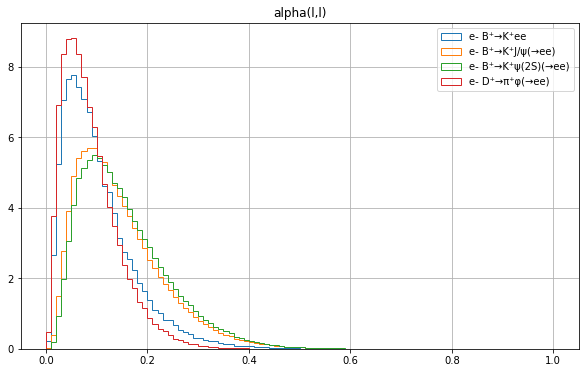

In [73]:
for idx in range(4):
    plt.hist(truthed[idx]['alpha'], label="e- %s"%df_index[idx],
             density=True, bins=np.linspace(0, 1.0, 101), histtype='step')
plt.title('alpha(l,l)')
plt.legend()
plt.grid()
plt.show()

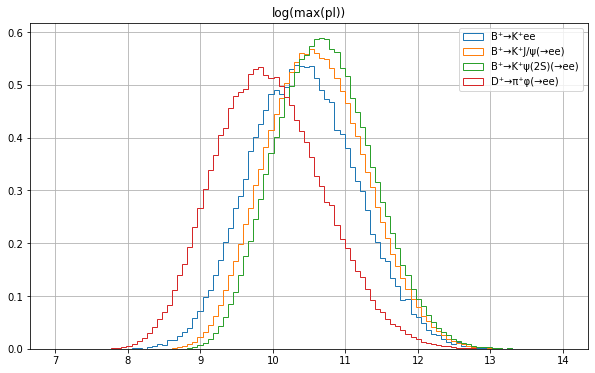

In [74]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['log_max_pl'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(7, 14, 101), histtype='step')
plt.title(r'log(max(pl))')
plt.legend()
plt.grid()
plt.show()

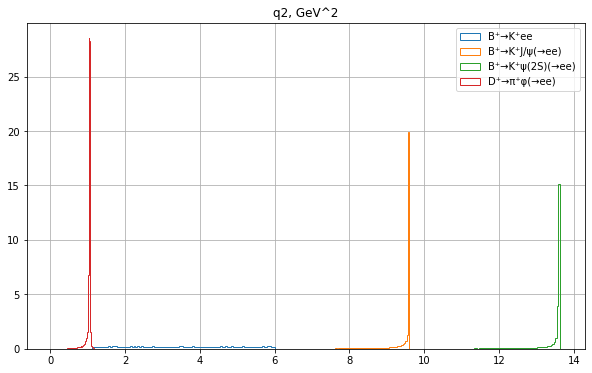

In [75]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['q2']*1e-6, label="%s"%df_index[idx],
             density=True, bins=100, histtype='step')
plt.title(r'q2, GeV^2')
plt.legend()
plt.grid()
plt.show()

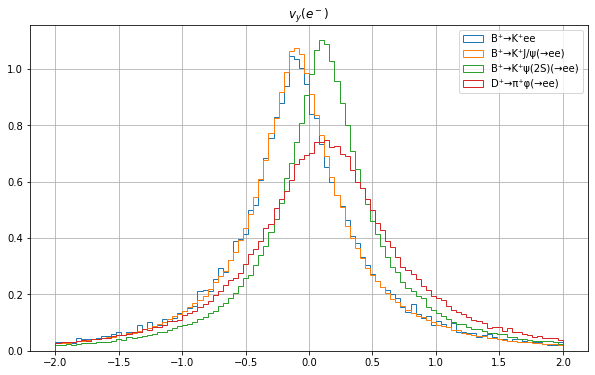

In [225]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['e_plus_TRUEORIGINVERTEX_Y'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(-2,2,101), histtype='step')
plt.title(r'$v_y(e^-)$')
plt.legend()
plt.grid()
plt.show()

### Preprocessing

In [81]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [84]:
def make_dataset(fnames, idx):
    x = list()
    y = list()
    mapping = dict()
    for i, ix in enumerate(idx):
        x_ = np.hstack([truthed[ix][fn].reshape(-1, 1) for fn in fnames])
        y_ = np.repeat(i, x_.shape[0])
        x.append(x_)
        y.append(y_)
        mapping[i] = ix
    X = np.vstack(x)
    Y = np.hstack(y)
    return X, Y, mapping

In [87]:
class Dataset():
    def __init__(self, features, idx):
        self.features = features
        self.indices = idx
        X, Y, mapping = make_dataset(features, idx)
        x_train, x_test, y_train, y_test = \
            sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)
        self.X = X
        self.Y = Y
        self.mapping = mapping
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(x_train)
        self.counts = np.asarray([np.sum(y_train==label) for label in sorted(mapping.keys())])
        self.weights = y_train.shape[0]/self.counts/self.counts.shape[0]
    def torch_dataset(self):
        dataset = torch.utils.data.TensorDataset(
            from_numpy(self.scaler.transform(self.x_train)),
            from_numpy(self.y_train, dtype=torch.long)
        )
        return dataset

In [129]:
def plot_ds(dataset):
    for label in sorted(dataset.mapping.keys()):
        idx = dataset.y_train==label
        x = dataset.x_train[idx][:10000,0:2]
        plt.scatter(*(x.T), marker=".", s=0.1, label="%s"%df_index[dataset.mapping[label]])
    #plt.gca().set_aspect('equal')
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-2*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(2*ones)[0,0:2]
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.plot()
    plt.legend()
    plt.grid()
    plt.show()

In [91]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

### NN

In [93]:
def model(inputs=2, outputs=4):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [94]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        total_count = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            count = x.shape[0]
            total_loss += loss
            total_count += count
            if not accumulate:
                loss /= count
                opt.zero_grad()
                loss.backward()
                opt.step()
        total_loss /= total_count
        if accumulate:
            opt.zero_grad()
            total_loss.backward()
            opt.step()
        logging.info("Epoch %d, %f", epoch, total_loss)
    model.eval()

### Weight limits estimation

$$\begin{aligned}
\inf_x\frac{p_1(x)}{p_0(x)}
\leq
\frac{\mathbb{E}_{x\sim p_1}[w(x)]}{\mathbb{E}_{x\sim p_0}[w(x)]}
\leq
\sup_x\frac{p_1(x)}{p_0(x)}
.
\end{aligned}$$

In [139]:
def plot_field(f, dataset, name=None, save=None, vmin=0.0, vmax=1.0):
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-3*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(3*ones)[0,0:2]
    X_test = np.random.rand(3000000, 2) * [x_max-x_min, y_max-y_min] + [x_min, y_min]
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.grid()
    #plt.gca().set_aspect('equal')
    if name is not None:
        plt.title(name)
    if save is not None:
        plt.savefig(save)
    plt.show()

In [140]:
def plot_clf(ds, clf, c0, c1):
    fn = lambda x : x[:,c1] - x[:,c0]
    f = lambda x : to_numpy(torch.sigmoid(fn(clf(from_numpy(ds.scaler.transform(x))))))
    plot_field(f, ds, r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]]))

In [136]:
def plot_clf_min_max(ds, clf):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : to_numpy(torch.relu(torch.min(fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    f_max = lambda x : to_numpy(torch.relu(torch.min(-fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    plot_field(f_min, ds, r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$', vmax=None)
    plot_field(f_max, ds, r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$', vmax=None)

In [125]:
class Estimator():
    def __init__(self, features, idx):
        self.ds = Dataset(features, idx)
        self.model = model(len(features), len(list(idx))).to(device)
    def train(self):
        dataset = ds.torch_dataset()
        loader = Loader(dataset, batch_size=10000, shuffle=True, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=False)
        loader = Loader(dataset, batch_size=10000, shuffle=False, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=True)
        return self.model

In [143]:
e_la = Estimator(["alpha", "log_max_pl"], range(4))
e_la.train()

INFO:root:Epoch 0, 1.324213
INFO:root:Epoch 1, 0.929302
INFO:root:Epoch 2, 0.847389
INFO:root:Epoch 3, 0.838089
INFO:root:Epoch 4, 0.834666
INFO:root:Epoch 5, 0.832011
INFO:root:Epoch 6, 0.829799
INFO:root:Epoch 7, 0.826428
INFO:root:Epoch 8, 0.823041
INFO:root:Epoch 9, 0.819372
INFO:root:Epoch 10, 0.815465
INFO:root:Epoch 11, 0.811629
INFO:root:Epoch 12, 0.807459
INFO:root:Epoch 13, 0.803812
INFO:root:Epoch 14, 0.800219
INFO:root:Epoch 15, 0.797556
INFO:root:Epoch 16, 0.794943
INFO:root:Epoch 17, 0.792976
INFO:root:Epoch 18, 0.790988
INFO:root:Epoch 19, 0.789649
INFO:root:Epoch 20, 0.788144
INFO:root:Epoch 21, 0.786813
INFO:root:Epoch 22, 0.785597
INFO:root:Epoch 23, 0.784588
INFO:root:Epoch 24, 0.783460
INFO:root:Epoch 25, 0.782589
INFO:root:Epoch 26, 0.781700
INFO:root:Epoch 27, 0.780980
INFO:root:Epoch 28, 0.780241
INFO:root:Epoch 29, 0.779863
INFO:root:Epoch 30, 0.779093
INFO:root:Epoch 31, 0.778642
INFO:root:Epoch 32, 0.778577
INFO:root:Epoch 33, 0.777799
INFO:root:Epoch 34, 0.77

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

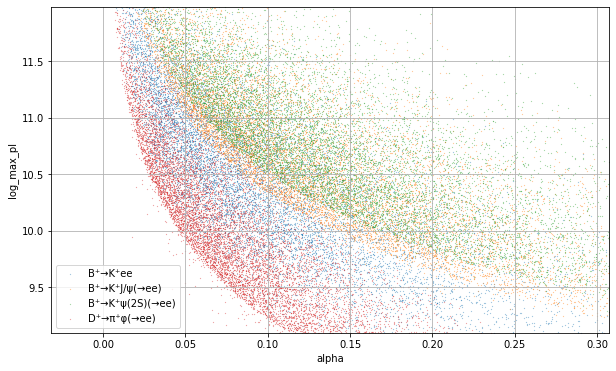

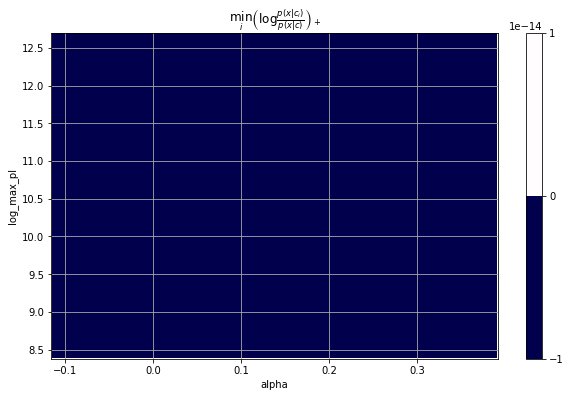

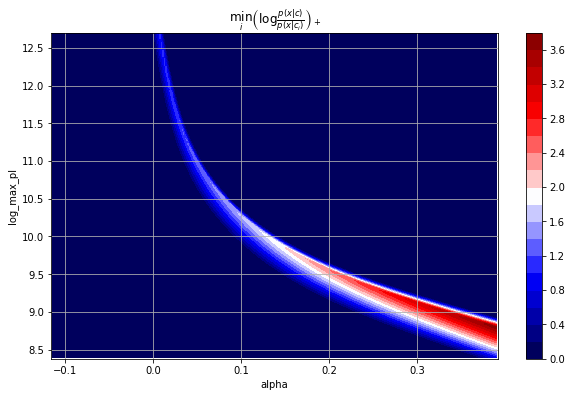

In [145]:
plot_ds(e_la.ds)
plot_clf_min_max(e_la.ds, e_la.model)

In [146]:
e_ptpt = Estimator(["e_minus_TRUEPT", "e_plus_TRUEPT"], range(4))
e_ptpt.train()

INFO:root:Epoch 0, 1.367227
INFO:root:Epoch 1, 0.995559
INFO:root:Epoch 2, 0.863149
INFO:root:Epoch 3, 0.823483
INFO:root:Epoch 4, 0.811978
INFO:root:Epoch 5, 0.804621
INFO:root:Epoch 6, 0.799208
INFO:root:Epoch 7, 0.795352
INFO:root:Epoch 8, 0.793015
INFO:root:Epoch 9, 0.790689
INFO:root:Epoch 10, 0.788941
INFO:root:Epoch 11, 0.787487
INFO:root:Epoch 12, 0.786479
INFO:root:Epoch 13, 0.785064
INFO:root:Epoch 14, 0.783735
INFO:root:Epoch 15, 0.782708
INFO:root:Epoch 16, 0.782052
INFO:root:Epoch 17, 0.781227
INFO:root:Epoch 18, 0.780014
INFO:root:Epoch 19, 0.779419
INFO:root:Epoch 20, 0.778842
INFO:root:Epoch 21, 0.778239
INFO:root:Epoch 22, 0.777493
INFO:root:Epoch 23, 0.777177
INFO:root:Epoch 24, 0.776743
INFO:root:Epoch 25, 0.776057
INFO:root:Epoch 26, 0.775943
INFO:root:Epoch 27, 0.775247
INFO:root:Epoch 28, 0.774951
INFO:root:Epoch 29, 0.775174
INFO:root:Epoch 30, 0.774389
INFO:root:Epoch 31, 0.774423
INFO:root:Epoch 32, 0.773812
INFO:root:Epoch 33, 0.773742
INFO:root:Epoch 34, 0.77

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

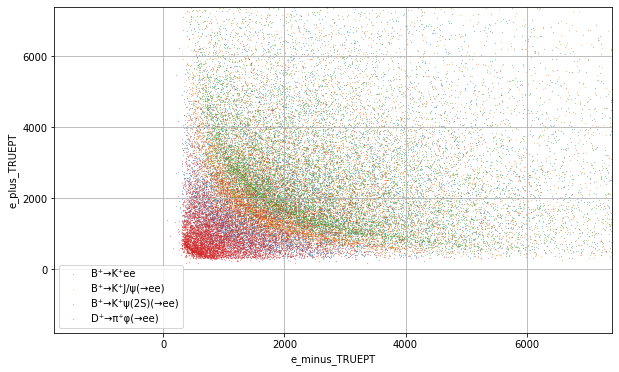

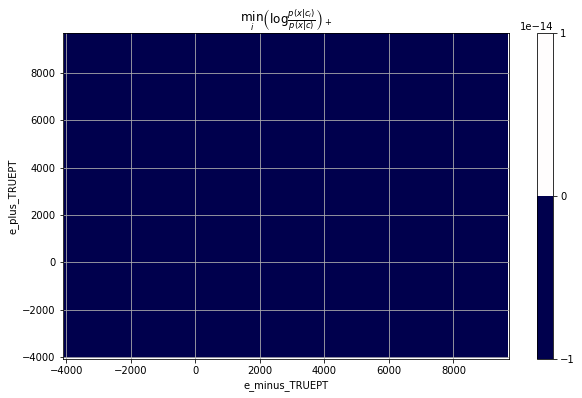

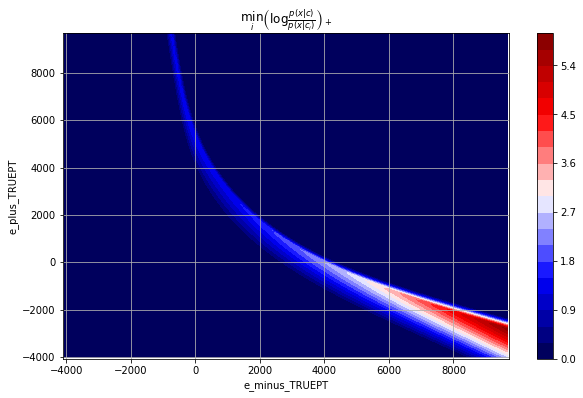

In [147]:
plot_ds(e_ptpt.ds)
plot_clf_min_max(e_ptpt.ds, e_ptpt.model)

In [209]:
e_vy = Estimator(["e_minus_TRUEORIGINVERTEX_Y", "e_minus_TRUEPT"], range(4))
e_vy.train()

INFO:root:Epoch 0, 1.366700
INFO:root:Epoch 1, 1.020721
INFO:root:Epoch 2, 0.853758
INFO:root:Epoch 3, 0.830315
INFO:root:Epoch 4, 0.823282
INFO:root:Epoch 5, 0.817146
INFO:root:Epoch 6, 0.810813
INFO:root:Epoch 7, 0.805274
INFO:root:Epoch 8, 0.801271
INFO:root:Epoch 9, 0.796901
INFO:root:Epoch 10, 0.794410
INFO:root:Epoch 11, 0.791826
INFO:root:Epoch 12, 0.790037
INFO:root:Epoch 13, 0.788208
INFO:root:Epoch 14, 0.786758
INFO:root:Epoch 15, 0.785089
INFO:root:Epoch 16, 0.783978
INFO:root:Epoch 17, 0.783169
INFO:root:Epoch 18, 0.782301
INFO:root:Epoch 19, 0.781177
INFO:root:Epoch 20, 0.780392
INFO:root:Epoch 21, 0.779768
INFO:root:Epoch 22, 0.779130
INFO:root:Epoch 23, 0.778558
INFO:root:Epoch 24, 0.778326
INFO:root:Epoch 25, 0.777962
INFO:root:Epoch 26, 0.777223
INFO:root:Epoch 27, 0.776828
INFO:root:Epoch 28, 0.777206
INFO:root:Epoch 29, 0.776573
INFO:root:Epoch 30, 0.776133
INFO:root:Epoch 31, 0.775990
INFO:root:Epoch 32, 0.775539
INFO:root:Epoch 33, 0.775961
INFO:root:Epoch 34, 0.77

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

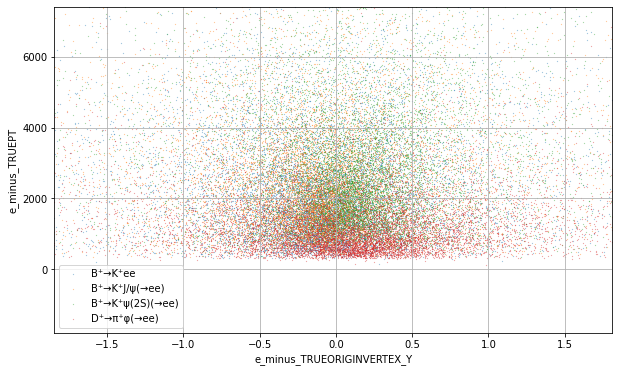

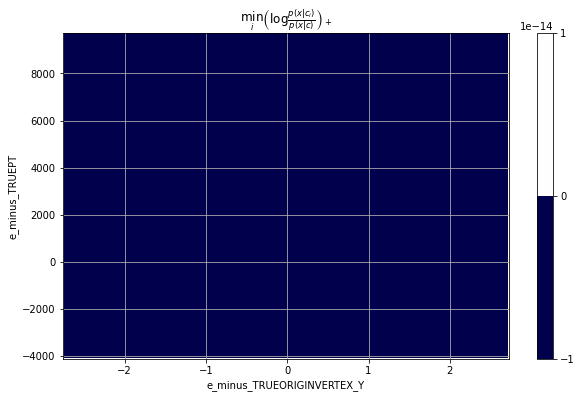

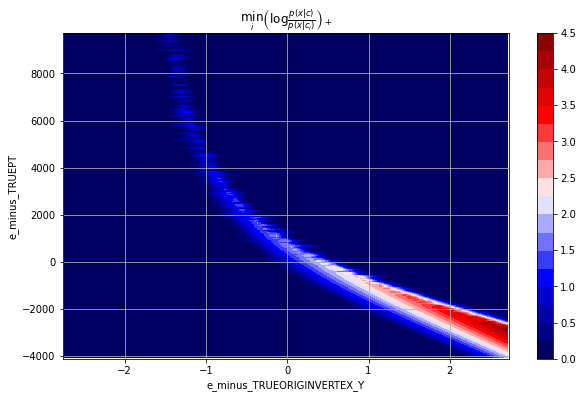

In [210]:
plot_ds(e_vy.ds)
plot_clf_min_max(e_vy.ds, e_vy.model)

### Crafting a loss

In [148]:
def ratio_estimator(vec):
    m_minus = np.sum(np.maximum(-vec, 0))
    m_plus = np.sum(np.maximum(vec, 0))
    return 1/m_minus

In [149]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = torch.softmax(model(x), dim=1) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W

In [150]:
def train_pinv(model, loader, selected_class, epochs=50, alpha=0.001):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    n_outs = 4 # N
    n_classes = 4 # n
    for epoch in range(epochs):
        W = create_w(model, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        det = np.linalg.det(W_np)
        W_pinv_ = from_numpy(W_pinv)
        
        wcj = W_pinv[selected_class]
        wcj_ = (wcj<0)
        wki = np.sum(W_pinv*wcj_[None,:], axis=1)
        W_m = np.multiply.outer(wcj, wki)
        W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
        #print(pred.shape, W.shape, W_pinv.shape)
        #print(W_pinv, w1j, wki, W_m)
        #print(ratio_estimator(w1j))
        #loss = torch.sum(W*from_numpy(W_m_))
        loss_c = torch.sum(W*from_numpy(W_m_))
        loss_d = -torch.sum(W*(W_pinv_.T))
        loss = loss_d + alpha * loss_c
        opt.zero_grad()
        loss.backward()
        opt.step()
        #logging.info("Epoch %d, loss=%f est=%f", epoch, loss, ratio_estimator(W_pinv[selected_class]))
        print("Epoch %d, loss=%f est=%f" % (epoch, loss, ratio_estimator(W_pinv[selected_class])),
              W_pinv[selected_class],
              det)
        #raise NotImplementedError
    model.eval()

In [178]:
@torch.no_grad()
def make_weighting(model, loader, selected_class):
    W = to_numpy(create_w(model, loader, 4, 4))
    print(W)
    print("|W| = ", np.linalg.det(W))
    Wpinv = np.linalg.pinv(W) # n*N
    print(Wpinv)
    w0 = Wpinv[selected_class]
    m_minus = np.max(-w0)
    m_plus = np.max(w0,0)
    m_sum = m_minus + m_plus
    linear = torch.nn.Linear(W.shape[0], 1, bias=False)
    linear.weight.data = from_numpy((w0 + m_minus)/m_sum)
    print(1/m_minus)
    print(linear.weight.data)
    return nn.Sequential(model, torch.nn.Softmax(dim=1), linear)

In [179]:
class Weighting():
    def __init__(self, estimator):
        self.estimator = estimator
        self.model = model(len(estimator.ds.features), len(list(estimator.ds.indices))).to(device)
        self.model.load_state_dict(estimator.model.state_dict())
    def train(self):
        loader = Loader(self.estimator.ds.torch_dataset(), batch_size=10000, shuffle=False, device=device)
        train_pinv(self.model, loader, 0, epochs=200, alpha=0.001)
        train_pinv(self.model, loader, 0, epochs=500, alpha=300)
    def w_model(self):
        loader = Loader(self.estimator.ds.torch_dataset(), batch_size=10000, shuffle=False, device=device)
        return make_weighting(self.model, loader, 0)
    def w_model_np(self):
        fn = self.w_model()
        fn_np = lambda x : to_numpy(fn(from_numpy(self.estimator.ds.scaler.transform(x))))
        return fn_np
    def dataset(self):
        return self.estimator.ds

In [180]:
w_la = Weighting(e_la)

In [181]:
w_la.train()

Epoch 0, loss=-4.000103 est=0.263026 [ 3.698  -2.5586  1.0846 -1.2433] 0.013227526
Epoch 1, loss=-4.000100 est=0.290242 [ 3.706  -2.2567  0.8261 -1.1887] 0.014790804
Epoch 2, loss=-4.000097 est=0.315966 [ 3.7079 -2.0197  0.6388 -1.1452] 0.016355317
Epoch 3, loss=-4.000095 est=0.340101 [ 3.6929 -1.8259  0.5003 -1.1144] 0.017943816
Epoch 4, loss=-4.000094 est=0.362526 [ 3.658  -1.6643  0.3971 -1.0941] 0.01956918
Epoch 5, loss=-4.000095 est=0.383158 [ 3.6048 -1.5268  0.3195 -1.0831] 0.021229982
Epoch 6, loss=-4.000095 est=0.401986 [ 3.5379 -1.4074  0.2603 -1.0802] 0.022914028
Epoch 7, loss=-4.000096 est=0.419133 [ 3.4629 -1.302   0.2143 -1.0839] 0.024604572
Epoch 8, loss=-4.000097 est=0.434865 [ 3.3851 -1.2072  0.1778 -1.0923] 0.026285337
Epoch 9, loss=-4.000099 est=0.449590 [ 3.3091 -1.1208  0.1483 -1.1035] 0.027944058
Epoch 10, loss=-4.000101 est=0.463784 [ 3.2386 -1.0414  0.1241 -1.1147] 0.029572535
Epoch 11, loss=-4.000102 est=0.477908 [ 3.1757 -0.9686  0.1042 -1.1238] 0.031165479
Epo

Epoch 100, loss=-4.000095 est=0.918822 [ 2.4641 -0.1989  0.0221 -0.8895] 0.06387824
Epoch 101, loss=-4.000095 est=0.920211 [ 2.463  -0.1982  0.022  -0.8885] 0.06394183
Epoch 102, loss=-4.000095 est=0.921562 [ 2.4619 -0.1975  0.0219 -0.8876] 0.06400452
Epoch 103, loss=-4.000095 est=0.922883 [ 2.4608 -0.1968  0.0219 -0.8868] 0.06406638
Epoch 104, loss=-4.000095 est=0.924178 [ 2.4598 -0.1961  0.0218 -0.8859] 0.06412734
Epoch 105, loss=-4.000095 est=0.925457 [ 2.4587 -0.1954  0.0217 -0.8851] 0.0641875
Epoch 106, loss=-4.000095 est=0.926727 [ 2.4576 -0.1947  0.0216 -0.8844] 0.064246826
Epoch 107, loss=-4.000094 est=0.927991 [ 2.4566 -0.194   0.0216 -0.8836] 0.064305395
Epoch 108, loss=-4.000094 est=0.929251 [ 2.4556 -0.1934  0.0215 -0.8827] 0.06436318
Epoch 109, loss=-4.000094 est=0.930506 [ 2.4547 -0.1928  0.0214 -0.8819] 0.064420216
Epoch 110, loss=-4.000094 est=0.931754 [ 2.4537 -0.1922  0.0214 -0.8811] 0.0644765
Epoch 111, loss=-4.000094 est=0.932991 [ 2.4528 -0.1916  0.0213 -0.8802] 0.

Epoch 0, loss=-31.456289 est=1.006198 [ 2.3967 -0.1601  0.0174 -0.8337] 0.06776091
Epoch 1, loss=-27.726070 est=1.126479 [ 2.5343 -0.1625  0.019  -0.7252] 0.06726086
Epoch 2, loss=-24.553822 est=1.249471 [ 2.6946 -0.15    0.0182 -0.6503] 0.06594823
Epoch 3, loss=-21.816816 est=1.373316 [ 2.8809 -0.1367  0.0171 -0.5915] 0.063892685
Epoch 4, loss=-19.460552 est=1.495103 [ 3.097  -0.1272  0.0163 -0.5416] 0.061215024
Epoch 5, loss=-17.442509 est=1.612730 [ 3.346  -0.1214  0.016  -0.4987] 0.058083277
Epoch 6, loss=-15.722793 est=1.724476 [ 3.6294 -0.1176  0.0159 -0.4623] 0.054672923
Epoch 7, loss=-14.262959 est=1.829244 [ 3.9472 -0.1148  0.0159 -0.4318] 0.051151082
Epoch 8, loss=-13.027042 est=1.926629 [ 4.2976 -0.1123  0.0159 -0.4067] 0.047661416
Epoch 9, loss=-11.982559 est=2.016727 [ 4.6774 -0.1097  0.0158 -0.3861] 0.044313643
Epoch 10, loss=-11.100455 est=2.099966 [ 5.0824 -0.1069  0.0157 -0.3693] 0.041180693
Epoch 11, loss=-10.355019 est=2.176932 [ 5.5081 -0.104   0.0154 -0.3554] 0.038

Epoch 99, loss=-6.620476 est=2.890059 [10.6512 -0.0736  0.0141 -0.2724] 0.02043906
Epoch 100, loss=-6.611390 est=2.894036 [10.676  -0.0736  0.0142 -0.272 ] 0.020393183
Epoch 101, loss=-6.602107 est=2.898090 [10.7015 -0.0735  0.0142 -0.2715] 0.020346373
Epoch 102, loss=-6.592669 est=2.902213 [10.7276 -0.0735  0.0142 -0.2711] 0.020298881
Epoch 103, loss=-6.583110 est=2.906393 [10.754  -0.0734  0.0142 -0.2706] 0.02025087
Epoch 104, loss=-6.573463 est=2.910619 [10.7808 -0.0734  0.0142 -0.2702] 0.020202506
Epoch 105, loss=-6.563762 est=2.914881 [10.8079 -0.0733  0.0142 -0.2697] 0.020153968
Epoch 106, loss=-6.554031 est=2.919173 [10.8351 -0.0733  0.0141 -0.2693] 0.020105418
Epoch 107, loss=-6.544288 est=2.923488 [10.8625 -0.0732  0.0141 -0.2688] 0.020056937
Epoch 108, loss=-6.534569 est=2.927816 [10.8898 -0.0732  0.0141 -0.2684] 0.02000872
Epoch 109, loss=-6.524885 est=2.932153 [10.9172 -0.0731  0.0141 -0.2679] 0.019960826
Epoch 110, loss=-6.515255 est=2.936495 [10.9445 -0.0731  0.0141 -0.26

Epoch 196, loss=-5.967083 est=3.271708 [12.5892 -0.072   0.0131 -0.2337] 0.017509023
Epoch 197, loss=-5.961828 est=3.275870 [12.6068 -0.0719  0.0131 -0.2333] 0.01748677
Epoch 198, loss=-5.956594 est=3.280036 [12.6243 -0.0719  0.0131 -0.2329] 0.017464627
Epoch 199, loss=-5.951389 est=3.284207 [12.6418 -0.0719  0.0131 -0.2326] 0.017442632
Epoch 200, loss=-5.946203 est=3.288383 [12.6593 -0.0719  0.0131 -0.2322] 0.017420745
Epoch 201, loss=-5.941045 est=3.292561 [12.6767 -0.0719  0.013  -0.2318] 0.017398998
Epoch 202, loss=-5.935914 est=3.296739 [12.694  -0.0719  0.013  -0.2314] 0.017377356
Epoch 203, loss=-5.930807 est=3.300920 [12.7113 -0.0719  0.013  -0.2311] 0.01735584
Epoch 204, loss=-5.925722 est=3.305106 [12.7285 -0.0719  0.013  -0.2307] 0.017334452
Epoch 205, loss=-5.920661 est=3.309295 [12.7457 -0.0719  0.013  -0.2303] 0.017313184
Epoch 206, loss=-5.915629 est=3.313483 [12.7628 -0.0719  0.013  -0.2299] 0.01729203
Epoch 207, loss=-5.910619 est=3.317676 [12.7799 -0.0719  0.013  -0.2

Epoch 294, loss=-5.559938 est=3.681151 [14.0319 -0.071   0.0119 -0.2006] 0.015834449
Epoch 295, loss=-5.556913 est=3.685077 [14.043  -0.071   0.0119 -0.2003] 0.015822375
Epoch 296, loss=-5.553914 est=3.688988 [14.0542 -0.071   0.0119 -0.2001] 0.015810393
Epoch 297, loss=-5.550926 est=3.692900 [14.0652 -0.071   0.0119 -0.1998] 0.01579849
Epoch 298, loss=-5.547970 est=3.696791 [14.0762 -0.071   0.0119 -0.1995] 0.01578667
Epoch 299, loss=-5.545026 est=3.700684 [14.0871 -0.071   0.0118 -0.1992] 0.015774935
Epoch 300, loss=-5.542105 est=3.704561 [14.098  -0.071   0.0118 -0.199 ] 0.015763262
Epoch 301, loss=-5.539209 est=3.708426 [14.1088 -0.071   0.0118 -0.1987] 0.015751699
Epoch 302, loss=-5.536332 est=3.712284 [14.1196 -0.0709  0.0118 -0.1984] 0.015740205
Epoch 303, loss=-5.533474 est=3.716130 [14.1303 -0.0709  0.0118 -0.1982] 0.015728772
Epoch 304, loss=-5.530632 est=3.719972 [14.1409 -0.0709  0.0118 -0.1979] 0.015717432
Epoch 305, loss=-5.527817 est=3.723800 [14.1515 -0.0709  0.0118 -0.

Epoch 392, loss=-5.334012 est=4.025993 [14.9787 -0.07    0.0111 -0.1784] 0.014900621
Epoch 393, loss=-5.332317 est=4.029010 [14.9869 -0.07    0.011  -0.1782] 0.014893339
Epoch 394, loss=-5.330630 est=4.032020 [14.9951 -0.07    0.011  -0.178 ] 0.014886103
Epoch 395, loss=-5.328953 est=4.035020 [15.0033 -0.07    0.011  -0.1778] 0.014878907
Epoch 396, loss=-5.327287 est=4.038009 [15.0115 -0.07    0.011  -0.1777] 0.014871743
Epoch 397, loss=-5.325628 est=4.040990 [15.0196 -0.07    0.011  -0.1775] 0.014864616
Epoch 398, loss=-5.323977 est=4.043964 [15.0277 -0.07    0.011  -0.1773] 0.014857529
Epoch 399, loss=-5.322339 est=4.046926 [15.0357 -0.07    0.011  -0.1771] 0.01485049
Epoch 400, loss=-5.320713 est=4.049871 [15.0438 -0.07    0.011  -0.1769] 0.0148434695
Epoch 401, loss=-5.319097 est=4.052806 [15.0518 -0.07    0.011  -0.1768] 0.014836496
Epoch 402, loss=-5.317486 est=4.055737 [15.0597 -0.07    0.011  -0.1766] 0.01482954
Epoch 403, loss=-5.315885 est=4.058655 [15.0677 -0.07    0.011  -0

Epoch 491, loss=-5.201394 est=4.283598 [15.6845 -0.0703  0.0107 -0.1631] 0.014304824
Epoch 492, loss=-5.200320 est=4.285846 [15.6908 -0.0703  0.0107 -0.163 ] 0.014299648
Epoch 493, loss=-5.199251 est=4.288088 [15.6971 -0.0703  0.0107 -0.1629] 0.014294497
Epoch 494, loss=-5.198181 est=4.290331 [15.7034 -0.0703  0.0107 -0.1628] 0.014289354
Epoch 495, loss=-5.197116 est=4.292570 [15.7096 -0.0703  0.0107 -0.1626] 0.0142842345
Epoch 496, loss=-5.196058 est=4.294791 [15.7159 -0.0703  0.0107 -0.1625] 0.014279113
Epoch 497, loss=-5.195006 est=4.297005 [15.7221 -0.0703  0.0107 -0.1624] 0.014274019
Epoch 498, loss=-5.193958 est=4.299216 [15.7283 -0.0703  0.0107 -0.1623] 0.014268934
Epoch 499, loss=-5.192913 est=4.301423 [15.7345 -0.0704  0.0107 -0.1621] 0.014263883


In [184]:
fn_la = w_la.w_model_np()

[[0.0695 0.0012 0.     0.0099]
 [0.2778 0.3683 0.1321 0.039 ]
 [0.1781 0.628  0.8679 0.0025]
 [0.4746 0.0025 0.     0.9485]]
|W| =  0.014258822
[[ 15.7407  -0.0704   0.0107  -0.162 ]
 [-13.3604   3.7276  -0.5672  -0.012 ]
 [  6.4601  -2.6826   1.5603   0.0386]
 [ -7.8404   0.0254  -0.0039   1.1354]]
6.172738990267769
tensor([1.0000, 0.0058, 0.0109, 0.0000], device='cuda:0')


In [186]:
w_ptpt = Weighting(e_ptpt)

In [187]:
w_ptpt.train()

Epoch 0, loss=-4.000010 est=0.010937 [ -8.2683 -83.1639  80.6673   7.6357] 0.00020140257
Epoch 1, loss=-4.000014 est=0.012442 [ -7.9254 -72.4486  68.0572   6.7496] 0.00024419682
Epoch 2, loss=-4.000018 est=0.013990 [ -7.5319 -63.9486  58.1792   6.0373] 0.0002903953
Epoch 3, loss=-4.000019 est=0.015573 [ -7.0367 -57.1764  50.3779   5.4496] 0.00033929062
Epoch 4, loss=-4.000018 est=0.017199 [ -6.3871 -51.755   44.1468   4.9477] 0.00039010923
Epoch 5, loss=-4.000020 est=0.018894 [ -5.5355 -47.3902  39.081    4.5019] 0.0004420304
Epoch 6, loss=-4.000024 est=0.020710 [ -4.4488 -43.8362  34.8687   4.0879] 0.00049430336
Epoch 7, loss=-4.000024 est=0.022731 [ -3.116  -40.8777  31.2723   3.6858] 0.0005464751
Epoch 8, loss=-4.000026 est=0.025078 [ -1.551  -38.325   28.1126   3.2781] 0.0005986347
Epoch 9, loss=-4.000028 est=0.027768 [  0.2081 -36.0133  25.2552   2.8487] 0.00065152964
Epoch 10, loss=-4.000030 est=0.029586 [  2.1033 -33.7993  22.5974   2.3819] 0.0007066384
Epoch 11, loss=-4.000032 

Epoch 96, loss=-4.000108 est=0.123590 [ 8.0652 -2.292   0.1827 -5.7993] 0.0052386713
Epoch 97, loss=-4.000108 est=0.123783 [ 8.0548 -2.2879  0.182  -5.7908] 0.00525051
Epoch 98, loss=-4.000109 est=0.123938 [ 8.0415 -2.2848  0.1814 -5.7837] 0.005262138
Epoch 99, loss=-4.000109 est=0.124062 [ 8.0256 -2.2826  0.181  -5.7779] 0.0052735764
Epoch 100, loss=-4.000109 est=0.124159 [ 8.0078 -2.2809  0.1806 -5.7733] 0.0052847983
Epoch 101, loss=-4.000109 est=0.124235 [ 7.9886 -2.2796  0.1804 -5.7697] 0.0052958084
Epoch 102, loss=-4.000109 est=0.124299 [ 7.9688 -2.2784  0.1801 -5.7667] 0.0053065936
Epoch 103, loss=-4.000110 est=0.124356 [ 7.949  -2.2773  0.18   -5.7642] 0.0053171716
Epoch 104, loss=-4.000110 est=0.124412 [ 7.9298 -2.2759  0.1798 -5.7619] 0.005327539
Epoch 105, loss=-4.000110 est=0.124475 [ 7.9116 -2.2743  0.1796 -5.7595] 0.0053376993
Epoch 106, loss=-4.000111 est=0.124548 [ 7.8948 -2.2721  0.1793 -5.7569] 0.005347683
Epoch 107, loss=-4.000110 est=0.124635 [ 7.8799 -2.2695  0.179 

Epoch 192, loss=-4.000116 est=0.133437 [ 7.4527 -2.0434  0.1532 -5.4507] 0.005958144
Epoch 193, loss=-4.000116 est=0.133514 [ 7.4488 -2.0418  0.153  -5.4481] 0.005964435
Epoch 194, loss=-4.000116 est=0.133590 [ 7.4449 -2.0402  0.1528 -5.4454] 0.0059707444
Epoch 195, loss=-4.000116 est=0.133666 [ 7.441  -2.0386  0.1527 -5.4428] 0.0059770616
Epoch 196, loss=-4.000116 est=0.133741 [ 7.437  -2.037   0.1525 -5.4401] 0.0059833894
Epoch 197, loss=-4.000117 est=0.133816 [ 7.4331 -2.0355  0.1524 -5.4375] 0.005989727
Epoch 198, loss=-4.000117 est=0.133890 [ 7.4291 -2.0339  0.1523 -5.4349] 0.0059960787
Epoch 199, loss=-4.000117 est=0.133964 [ 7.4251 -2.0324  0.1521 -5.4323] 0.0060024313
Epoch 0, loss=-39.047588 est=0.134037 [ 7.4212 -2.0309  0.152  -5.4297] 0.0060088043
Epoch 1, loss=-35.252602 est=0.142320 [ 8.1113 -2.2046  0.1907 -4.8218] 0.0059209955
Epoch 2, loss=-32.002254 est=0.148767 [ 8.9182 -2.2558  0.2123 -4.4661] 0.005736067
Epoch 3, loss=-29.175119 est=0.154648 [ 9.8129 -2.1865  0.213

Epoch 89, loss=-16.038649 est=0.189109 [20.4709 -1.2989  0.2687 -3.9891] 0.0030331684
Epoch 90, loss=-16.050922 est=0.189184 [20.4557 -1.2979  0.2691 -3.988 ] 0.0030345337
Epoch 91, loss=-16.057568 est=0.189265 [20.4496 -1.2966  0.2694 -3.987 ] 0.0030347784
Epoch 92, loss=-16.058819 est=0.189352 [20.4525 -1.2951  0.2698 -3.986 ] 0.0030339407
Epoch 93, loss=-16.055134 est=0.189446 [20.4635 -1.2937  0.2701 -3.9849] 0.0030321113
Epoch 94, loss=-16.047070 est=0.189544 [20.4818 -1.2923  0.2704 -3.9835] 0.0030294014
Epoch 95, loss=-16.035519 est=0.189646 [20.5059 -1.291   0.2707 -3.982 ] 0.0030259932
Epoch 96, loss=-16.021399 est=0.189751 [20.5344 -1.2899  0.2711 -3.9802] 0.0030220735
Epoch 97, loss=-16.005772 est=0.189859 [20.5655 -1.2887  0.2715 -3.9783] 0.0030178763
Epoch 98, loss=-15.989691 est=0.189966 [20.5975 -1.2876  0.2719 -3.9765] 0.0030136127
Epoch 99, loss=-15.974127 est=0.190074 [20.6287 -1.2864  0.2722 -3.9748] 0.0030094993
Epoch 100, loss=-15.959900 est=0.190180 [20.6577 -1.28

Epoch 186, loss=-16.397781 est=0.200622 [20.8597 -1.2242  0.3065 -3.7603] 0.0030568647
Epoch 187, loss=-16.383858 est=0.200846 [20.905  -1.2222  0.3067 -3.7567] 0.003053255
Epoch 188, loss=-16.368965 est=0.201074 [20.9523 -1.2201  0.3069 -3.7531] 0.003049471
Epoch 189, loss=-16.353123 est=0.201306 [21.0017 -1.218   0.3071 -3.7495] 0.0030455275
Epoch 190, loss=-16.336395 est=0.201543 [21.0532 -1.2159  0.3073 -3.7459] 0.0030414388
Epoch 191, loss=-16.318832 est=0.201784 [21.1067 -1.2136  0.3075 -3.7422] 0.003037215
Epoch 192, loss=-16.300468 est=0.202029 [21.1621 -1.2114  0.3076 -3.7384] 0.003032847
Epoch 193, loss=-16.281401 est=0.202278 [21.2193 -1.2091  0.3077 -3.7346] 0.0030283523
Epoch 194, loss=-16.261673 est=0.202531 [21.2782 -1.2067  0.3078 -3.7308] 0.0030237266
Epoch 195, loss=-16.241243 est=0.202788 [21.3387 -1.2043  0.3079 -3.7269] 0.0030189618
Epoch 196, loss=-16.220125 est=0.203048 [21.4006 -1.2019  0.308  -3.723 ] 0.003014056
Epoch 197, loss=-16.198162 est=0.203309 [21.4637

Epoch 281, loss=-13.842948 est=0.221426 [26.4073 -0.9863  0.0753 -3.5299] 0.0031857342
Epoch 282, loss=-13.834091 est=0.221598 [26.4346 -0.9859  0.0753 -3.5268] 0.003183996
Epoch 283, loss=-13.825825 est=0.221766 [26.4601 -0.9855  0.0753 -3.5237] 0.0031824003
Epoch 284, loss=-13.816517 est=0.221933 [26.4881 -0.9851  0.0752 -3.5207] 0.0031805898
Epoch 285, loss=-13.804605 est=0.222102 [26.5223 -0.9847  0.075  -3.5177] 0.0031782226
Epoch 286, loss=-13.788919 est=0.222274 [26.5658 -0.9841  0.0747 -3.5148] 0.0031750384
Epoch 287, loss=-13.768846 est=0.222450 [26.62   -0.9834  0.0743 -3.5119] 0.0031709103
Epoch 288, loss=-13.744482 est=0.222631 [26.6848 -0.9827  0.0738 -3.509 ] 0.003165886
Epoch 289, loss=-13.716611 est=0.222815 [26.7582 -0.982   0.0732 -3.5061] 0.0031601947
Epoch 290, loss=-13.686639 est=0.222998 [26.8368 -0.9813  0.0726 -3.5031] 0.0031542256
Epoch 291, loss=-13.656279 est=0.223179 [26.916  -0.9806  0.0719 -3.5001] 0.0031484382
Epoch 292, loss=-13.627237 est=0.223353 [26.9

Epoch 377, loss=-13.197645 est=0.231069 [28.0308 -0.9449  0.0632 -3.3828] 0.0031138891
Epoch 378, loss=-13.197133 est=0.231132 [28.0302 -0.9445  0.0632 -3.382 ] 0.0031143597
Epoch 379, loss=-13.196604 est=0.231196 [28.0296 -0.9441  0.0632 -3.3813] 0.0031148226
Epoch 380, loss=-13.196071 est=0.231259 [28.0291 -0.9436  0.0632 -3.3805] 0.0031152782
Epoch 381, loss=-13.195527 est=0.231322 [28.0286 -0.9432  0.0632 -3.3798] 0.0031157264
Epoch 382, loss=-13.195013 est=0.231384 [28.028  -0.9428  0.0632 -3.379 ] 0.0031161865
Epoch 383, loss=-13.194494 est=0.231447 [28.0273 -0.9424  0.0631 -3.3783] 0.003116643
Epoch 384, loss=-13.193965 est=0.231509 [28.0268 -0.942   0.0631 -3.3775] 0.0031170922
Epoch 385, loss=-13.193444 est=0.231572 [28.0262 -0.9415  0.0631 -3.3768] 0.003117549
Epoch 386, loss=-13.192865 est=0.231634 [28.0257 -0.9411  0.0631 -3.376 ] 0.0031179853
Epoch 387, loss=-13.192259 est=0.231695 [28.0253 -0.9407  0.0631 -3.3753] 0.003118412
Epoch 388, loss=-13.191647 est=0.231757 [28.02

Epoch 474, loss=-13.192738 est=0.236445 [27.8358 -0.9093  0.0632 -3.32  ] 0.0031645272
Epoch 475, loss=-13.193236 est=0.236494 [27.8321 -0.909   0.0632 -3.3195] 0.003165178
Epoch 476, loss=-13.193761 est=0.236542 [27.8284 -0.9086  0.0632 -3.3189] 0.003165835
Epoch 477, loss=-13.194284 est=0.236591 [27.8247 -0.9083  0.0631 -3.3184] 0.0031664958
Epoch 478, loss=-13.194816 est=0.236639 [27.821  -0.908   0.0631 -3.3179] 0.0031671526
Epoch 479, loss=-13.195356 est=0.236688 [27.8172 -0.9077  0.0631 -3.3173] 0.0031678204
Epoch 480, loss=-13.195912 est=0.236736 [27.8134 -0.9073  0.0631 -3.3168] 0.0031684863
Epoch 481, loss=-13.196473 est=0.236784 [27.8095 -0.907   0.0631 -3.3162] 0.0031691552
Epoch 482, loss=-13.197020 est=0.236832 [27.8057 -0.9067  0.0631 -3.3157] 0.0031698218
Epoch 483, loss=-13.197593 est=0.236880 [27.8018 -0.9064  0.0631 -3.3152] 0.0031704977
Epoch 484, loss=-13.198176 est=0.236928 [27.7979 -0.906   0.0631 -3.3146] 0.0031711776
Epoch 485, loss=-13.198771 est=0.236976 [27.7

In [188]:
fn_ptpt = w_ptpt.w_model_np()

[[0.0573 0.01   0.0029 0.0638]
 [0.2862 0.3368 0.1473 0.2614]
 [0.5456 0.6488 0.8492 0.2074]
 [0.1108 0.0044 0.0006 0.4674]]
|W| =  0.0031824666
[[ 27.7312  -0.9009   0.063   -3.3064]
 [-17.2399   5.0567  -0.8175  -0.1141]
 [ -3.0802  -3.3262   1.764    1.4979]
 [ -6.4111   0.1705  -0.0095   2.9226]]
0.3024463569789486
tensor([1.0000, 0.0775, 0.1086, 0.0000], device='cuda:0')


In [211]:
w_vy = Weighting(e_vy)
w_vy.train()
fn_vy = w_vy.w_model_np()

Epoch 0, loss=-4.000010 est=0.005914 [-128.9557  -40.1472   41.3661  220.3988] -9.56855e-07
Epoch 1, loss=-4.000004 est=0.007878 [-57.6646 -69.2762  47.8824 134.6977] -2.6918622e-06
Epoch 2, loss=-4.000006 est=0.008548 [-40.7626 -76.23    45.644  115.3826] -4.293974e-06
Epoch 3, loss=-4.000011 est=0.008941 [-32.0758 -79.7688  42.6712 105.4253] -5.8323853e-06
Epoch 4, loss=-4.000013 est=0.009225 [-26.3448 -82.0513  39.7921  98.562 ] -7.335411e-06
Epoch 5, loss=-4.000011 est=0.009455 [-22.0761 -83.6851  37.1766  93.1062] -8.816369e-06
Epoch 6, loss=-4.000009 est=0.009654 [-18.6651 -84.9194  34.8545  88.4316] -1.0282347e-05
Epoch 7, loss=-4.000011 est=0.009833 [-15.8161 -85.8822  32.8155  84.2711] -1.1735106e-05
Epoch 8, loss=-4.000010 est=0.010000 [-13.3548 -86.6434  31.0349  80.4791] -1.31771085e-05
Epoch 9, loss=-4.000013 est=0.010161 [-11.1858 -87.2297  29.4786  76.9896] -1.4607852e-05
Epoch 10, loss=-4.000009 est=0.010321 [ -9.2382 -87.6562  28.116   73.7471] -1.6030946e-05
Epoch 11,

Epoch 91, loss=-4.000019 est=0.021440 [ 21.7154 -44.1158  23.1102  -2.5263] -0.00022787352
Epoch 92, loss=-4.000019 est=0.021239 [ 21.5502 -44.0311  23.3299  -3.0524] -0.00023224628
Epoch 93, loss=-4.000019 est=0.021054 [ 21.4181 -43.9523  23.5407  -3.5437] -0.000236536
Epoch 94, loss=-4.000021 est=0.020888 [ 21.3188 -43.8784  23.7411  -3.9966] -0.0002407785
Epoch 95, loss=-4.000020 est=0.020740 [ 21.2498 -43.8068  23.9294  -4.4093] -0.00024500678
Epoch 96, loss=-4.000021 est=0.020611 [ 21.2081 -43.7353  24.1048  -4.7816] -0.00024924142
Epoch 97, loss=-4.000020 est=0.020501 [ 21.19   -43.6618  24.2674  -5.1153] -0.00025349087
Epoch 98, loss=-4.000021 est=0.020408 [ 21.192  -43.5859  24.4183  -5.4134] -0.0002577469
Epoch 99, loss=-4.000021 est=0.020331 [ 21.2096 -43.5059  24.559   -5.6797] -0.00026200205
Epoch 100, loss=-4.000022 est=0.020268 [ 21.2381 -43.4209  24.691   -5.9185] -0.00026624513
Epoch 101, loss=-4.000021 est=0.020217 [ 21.2725 -43.3294  24.8164  -6.1342] -0.0002704683
Ep

Epoch 181, loss=-4.000035 est=0.025874 [ 16.4407 -28.5575  28.0017 -10.0907] -0.0005827788
Epoch 182, loss=-4.000035 est=0.025931 [ 16.4323 -28.4534  27.9322 -10.1103] -0.00058657496
Epoch 183, loss=-4.000035 est=0.025990 [ 16.4255 -28.3481  27.8577 -10.1281] -0.00059039076
Epoch 184, loss=-4.000035 est=0.026051 [ 16.4203 -28.2421  27.7789 -10.1442] -0.00059422484
Epoch 185, loss=-4.000036 est=0.026114 [ 16.4163 -28.1354  27.696  -10.1589] -0.00059808337
Epoch 186, loss=-4.000035 est=0.026178 [ 16.4133 -28.0285  27.6098 -10.1722] -0.0006019656
Epoch 187, loss=-4.000035 est=0.026243 [ 16.4109 -27.9213  27.5206 -10.1846] -0.00060587365
Epoch 188, loss=-4.000035 est=0.026309 [ 16.4089 -27.8143  27.4289 -10.196 ] -0.00060981157
Epoch 189, loss=-4.000036 est=0.026375 [ 16.4068 -27.7076  27.3355 -10.2069] -0.00061377895
Epoch 190, loss=-4.000036 est=0.026442 [ 16.4043 -27.6015  27.2408 -10.2174] -0.0006177763
Epoch 191, loss=-4.000036 est=0.026508 [ 16.4012 -27.4961  27.1452 -10.2277] -0.000

Epoch 72, loss=-10.452909 est=0.083378 [ 46.4907 -11.9935  33.5265   0.1579] -0.00016074156
Epoch 73, loss=-10.493000 est=0.083562 [ 46.2036 -11.9672  33.6117   0.1057] -0.00016119862
Epoch 74, loss=-8.070120 est=0.083543 [ 45.4149 -11.933   33.8122  -0.0369] -0.00016286451
Epoch 75, loss=-8.038413 est=0.083929 [ 45.652  -11.913   33.7946  -0.0017] -0.00016193122
Epoch 76, loss=-10.407574 est=0.083992 [ 46.8196 -11.9059  33.5846   0.1911] -0.00015868871
Epoch 77, loss=-10.338197 est=0.084107 [ 47.3321 -11.8896  33.5161   0.2691] -0.0001570779
Epoch 78, loss=-10.355377 est=0.084280 [ 47.2041 -11.8652  33.5722   0.2428] -0.00015701578
Epoch 79, loss=-10.450066 est=0.084507 [ 46.5111 -11.8334  33.7417   0.1213] -0.00015832037
Epoch 80, loss=-8.030901 est=0.084161 [ 45.3698 -11.795   34.0183  -0.087 ] -0.00016073797
Epoch 81, loss=-8.028320 est=0.084205 [ 45.3302 -11.7719  34.0676  -0.1039] -0.00016045019
Epoch 82, loss=-10.483755 est=0.085016 [ 46.2694 -11.7625  33.9124   0.0525] -0.00015

Epoch 164, loss=-9.750203 est=0.094021 [ 52.172  -10.6359  35.2945   0.1031] -0.00014071805
Epoch 165, loss=-9.701793 est=0.094056 [ 52.615  -10.632   35.1926   0.1577] -0.00014011192
Epoch 166, loss=-9.738764 est=0.094178 [ 52.2761 -10.6182  35.2185   0.0936] -0.00014100403
Epoch 167, loss=-7.402116 est=0.093692 [ 51.271  -10.5956  35.362   -0.0776] -0.00014319413
Epoch 168, loss=-7.385653 est=0.093962 [ 51.4974 -10.5899  35.2849  -0.0528] -0.00014302017
Epoch 169, loss=-9.677379 est=0.094346 [ 52.8413 -10.5992  35.0133   0.1457] -0.00014071274
Epoch 170, loss=-9.624460 est=0.094361 [ 53.3384 -10.5977  34.8883   0.2101] -0.0001400493
Epoch 171, loss=-9.658590 est=0.094464 [ 53.0167 -10.5861  34.893    0.1538] -0.00014094634
Epoch 172, loss=-7.352561 est=0.094544 [ 51.9933 -10.5654  35.016   -0.0117] -0.0001432055
Epoch 173, loss=-9.747067 est=0.094685 [ 52.2005 -10.5614  34.9276   0.0137] -0.00014311033
Epoch 174, loss=-7.379666 est=0.094133 [ 51.6859 -10.5473  34.9679  -0.076 ] -0.00

Epoch 256, loss=-7.308357 est=0.098116 [ 54.0994 -10.1484  31.2765  -0.0436] -0.00016222267
Epoch 257, loss=-9.415998 est=0.098420 [ 55.3915 -10.1605  31.0719   0.1402] -0.00015972079
Epoch 258, loss=-9.378353 est=0.098420 [ 55.7792 -10.1606  30.9975   0.1887] -0.00015915098
Epoch 259, loss=-9.424643 est=0.098529 [ 55.3032 -10.1493  31.0381   0.1153] -0.00016039927
Epoch 260, loss=-7.314923 est=0.098079 [ 54.1073 -10.1283  31.1845  -0.0676] -0.00016320223
Epoch 261, loss=-7.308509 est=0.098213 [ 54.2198 -10.1247  31.1471  -0.0572] -0.00016321102
Epoch 262, loss=-9.404336 est=0.098649 [ 55.511  -10.1369  30.9458   0.1254] -0.0001607025
Epoch 263, loss=-9.367077 est=0.098649 [ 55.8964 -10.1369  30.8743   0.173 ] -0.00016013482
Epoch 264, loss=-9.413456 est=0.098761 [ 55.4175 -10.1255  30.9176   0.0987] -0.000161392
Epoch 265, loss=-7.316297 est=0.098142 [ 54.2186 -10.1042  31.0666  -0.0851] -0.0001642073
Epoch 266, loss=-7.310161 est=0.098268 [ 54.3296 -10.1005  31.032   -0.0757] -0.0001

Epoch 348, loss=-9.128376 est=0.103107 [58.4981 -9.6987 30.5229  0.0534] -0.00016869928
Epoch 349, loss=-7.261861 est=0.101341 [56.6567 -9.6624 30.8089 -0.2053] -0.00017258855
Epoch 350, loss=-7.293572 est=0.100782 [56.2239 -9.6485 30.9041 -0.2739] -0.00017358887
Epoch 351, loss=-7.240924 est=0.101831 [57.0144 -9.6541 30.8169 -0.1661] -0.00017204846
Epoch 352, loss=-9.088005 est=0.103323 [58.9622 -9.6784 30.5781  0.0907] -0.00016816426
Epoch 353, loss=-9.009924 est=0.103245 [59.8811 -9.6857 30.4941  0.1997] -0.00016640883
Epoch 354, loss=-9.021822 est=0.103350 [59.7393 -9.6758 30.5417  0.1755] -0.00016677294
Epoch 355, loss=-9.113987 est=0.103619 [58.6626 -9.6507 30.7101  0.0314] -0.00016900845
Epoch 356, loss=-7.257741 est=0.101697 [56.8844 -9.6136 30.9965 -0.2195] -0.00017269835
Epoch 357, loss=-7.285649 est=0.101197 [56.5029 -9.5993 31.0873 -0.2824] -0.00017355538
Epoch 358, loss=-7.230418 est=0.102287 [57.3387 -9.6051 30.9918 -0.1713] -0.00017192386
Epoch 359, loss=-9.056622 est=0.

Epoch 442, loss=-9.006360 est=0.107094 [59.9238 -9.3376 29.9211  0.0852] -0.00018097497
Epoch 443, loss=-8.942334 est=0.106981 [60.7001 -9.3474 29.8312  0.1761] -0.00017950134
Epoch 444, loss=-8.967946 est=0.107090 [60.3871 -9.338  29.8764  0.1368] -0.00018030677
Epoch 445, loss=-7.206139 est=0.107168 [59.1378 -9.3118 30.0464 -0.0193] -0.0001830946
Epoch 446, loss=-7.205604 est=0.107226 [59.1627 -9.3079 30.0448 -0.0182] -0.0001831589
Epoch 447, loss=-8.972485 est=0.107249 [60.332  -9.3241 29.8888  0.124 ] -0.00018077534
Epoch 448, loss=-8.965797 est=0.107285 [60.4132 -9.321  29.8773  0.1318] -0.00018069857
Epoch 449, loss=-9.041870 est=0.107523 [59.5017 -9.3003 29.9951  0.0185] -0.00018272431
Epoch 450, loss=-7.296473 est=0.105614 [57.8235 -9.2659 30.2394 -0.2025] -0.00018642169
Epoch 451, loss=-7.319089 est=0.105219 [57.5099 -9.2558 30.2934 -0.2482] -0.00018721781
Epoch 452, loss=-7.261556 est=0.106391 [58.3925 -9.2668 30.169  -0.1325] -0.00018545028
Epoch 453, loss=-8.965895 est=0.10

### Result analysis

In [185]:
plot_field(fn_la, w_la.dataset(), r'$w(x)$', save='result.pdf')

In [189]:
plot_field(fn_ptpt, w_ptpt.dataset(), r'$w(x)$', save='result.pdf')

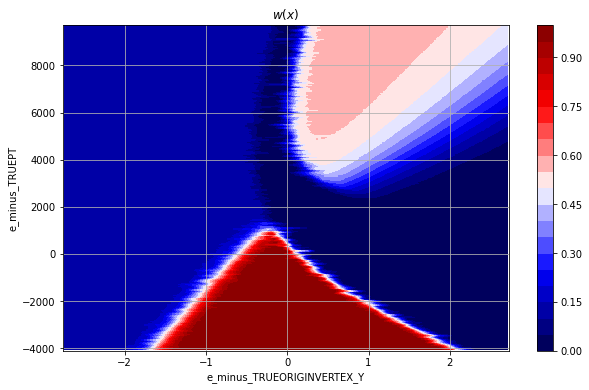

In [212]:
plot_field(fn_vy, w_vy.dataset(), r'$w(x)$')

In [213]:
df = df.iloc[0:8,0:3]

In [214]:
df["1-w"] = 1
df["w"] = 1
for label, idx in e_la.ds.mapping.items():
    d = e_la.ds.X[e_la.ds.Y==label]
    wd = fn_la(d)
    df.loc[df.index[idx],"w"] = np.mean(wd)
    df.loc[df.index[idx],"1-w"] = 1-np.mean(wd)
    #df.loc[df.index[idx],"min w"] = np.min(wd)
    #df.loc[df.index[idx],"max w"] = np.max(wd)
df

Total       N   N/Total       1-w         w
B⁺→K⁺ee           413741   36689  0.088676  0.927288  0.072712
B⁺→K⁺J/ψ(→ee)    2084124  731925  0.351191  0.989800  0.010200
B⁺→K⁺ψ(2S)(→ee)   869415  247181  0.284307  0.989812  0.010188
D⁺→π⁺φ(→ee)       499520  149292  0.298871  0.989847  0.010153

In [215]:
df["1-wpt"] = 1
df["wpt"] = 1
for label, idx in e_ptpt.ds.mapping.items():
    d = e_ptpt.ds.X[e_ptpt.ds.Y==label]
    wd = fn_ptpt(d)
    df.loc[df.index[idx],"wpt"] = np.mean(wd)
    df.loc[df.index[idx],"1-wpt"] = 1-np.mean(wd)
    #df.loc[df.index[idx],"min wpt"] = np.min(wd)
    #df.loc[df.index[idx],"max wpt"] = np.max(wd)
df

Total       N   N/Total       1-w         w     1-wpt  \
B⁺→K⁺ee           413741   36689  0.088676  0.927288  0.072712  0.861198   
B⁺→K⁺J/ψ(→ee)    2084124  731925  0.351191  0.989800  0.010200  0.893492   
B⁺→K⁺ψ(2S)(→ee)   869415  247181  0.284307  0.989812  0.010188  0.893527   
D⁺→π⁺φ(→ee)       499520  149292  0.298871  0.989847  0.010153  0.893577   

                      wpt  
B⁺→K⁺ee          0.138802  
B⁺→K⁺J/ψ(→ee)    0.106508  
B⁺→K⁺ψ(2S)(→ee)  0.106473  
D⁺→π⁺φ(→ee)      0.106423

In [216]:
df["1-wvy"] = 1
df["wvy"] = 1
for label, idx in e_vy.ds.mapping.items():
    d = e_vy.ds.X[e_vy.ds.Y==label]
    wd = fn_vy(d)
    df.loc[df.index[idx],"wvy"] = np.mean(wd)
    df.loc[df.index[idx],"1-wvy"] = 1-np.mean(wd)
    #df.loc[df.index[idx],"min wpt"] = np.min(wd)
    #df.loc[df.index[idx],"max wpt"] = np.max(wd)
df

Total       N   N/Total       1-w         w     1-wpt  \
B⁺→K⁺ee           413741   36689  0.088676  0.927288  0.072712  0.861198   
B⁺→K⁺J/ψ(→ee)    2084124  731925  0.351191  0.989800  0.010200  0.893492   
B⁺→K⁺ψ(2S)(→ee)   869415  247181  0.284307  0.989812  0.010188  0.893527   
D⁺→π⁺φ(→ee)       499520  149292  0.298871  0.989847  0.010153  0.893577   

                      wpt     1-wvy       wvy  
B⁺→K⁺ee          0.138802  0.858853  0.141147  
B⁺→K⁺J/ψ(→ee)    0.106508  0.873495  0.126505  
B⁺→K⁺ψ(2S)(→ee)  0.106473  0.873647  0.126353  
D⁺→π⁺φ(→ee)      0.106423  0.873391  0.126609

$$\begin{aligned}
R_K&=\frac{\mathcal{B}(B\to K\mu\mu)}{\mathcal{B}(B \to Kee)} \Big/ \frac{\mathcal{B}(B\to KJ/\psi(\to \mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
, \\
R_{\psi(2S)}&=\frac{\mathcal{B}(B\to K\psi(2S)(\to\mu\mu))}{\mathcal{B}(B \to K\psi(2S)(\to ee))} \Big/ \frac{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
, \\
r_{J/\psi}&=\frac{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
.
\end{aligned}$$

In [165]:
def r_K(a): return 1/a[0]
def r_Jpsi(a): return 1/a[1]
def r_psi2S(a): return 1/a[2]
def R_K(a): return r_K(a)/r_Jpsi(a)
def R_psi2S(a): return r_psi2S(a)/r_Jpsi(a)

def double_ratio(a): return R_K(a)
def double_ratio_psi2S(a): return R_psi2S(a)

In [166]:
double_ratio(df["1-w"]), double_ratio_psi2S(df["1-w"])

(1.0674136334892204, 0.9999876628074365)

In [167]:
1/double_ratio(df["1-w"]), 1/double_ratio_psi2S(df["1-w"])

(0.9368439456137965, 1.0000123373447718)

In [168]:
double_ratio(df["w"]), double_ratio_psi2S(df["w"])

(0.14028190861915124, 1.001198619539857)

In [169]:
1/double_ratio(df["w"]), 1/double_ratio_psi2S(df["w"])

(7.128502954111363, 0.9988028154289627)

### Conditional plots

In [217]:
X_q2, Y_q2, mapping_q2 = make_dataset(["alpha", "log_max_pl", "q2", "e_minus_TRUEPT", "e_plus_TRUEPT", "e_minus_TRUEORIGINVERTEX_Y"], range(4))

In [220]:
bins_q2 = np.linspace(0,14e6,101)
for label, idx in mapping_q2.items():
    d = X_q2[Y_q2==label]
    wd = 1-fn_la(d[:,0:2])
    q2d = d[:,2]
    h1 = np.histogram(q2d, bins=bins_q2)[0]
    hw = np.histogram(q2d, bins=bins_q2, weights=wd)[0]
    plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
plt.title("q2")
plt.grid()
plt.show()

for label, idx in mapping_q2.items():
    d = X_q2[Y_q2==label]
    wd = 1-fn_ptpt(d[:,3:5])
    q2d = d[:,2]
    h1 = np.histogram(q2d, bins=bins_q2)[0]
    hw = np.histogram(q2d, bins=bins_q2, weights=wd)[0]
    plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
plt.title("q2")
plt.grid()
plt.show()

for label, idx in mapping_q2.items():
    d = X_q2[Y_q2==label]
    wd = 1-fn_vy(d[:,[5,3]])
    q2d = d[:,2]
    h1 = np.histogram(q2d, bins=bins_q2)[0]
    hw = np.histogram(q2d, bins=bins_q2, weights=wd)[0]
    plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
plt.title("q2")
plt.grid()
plt.show()

<ipython-input-220-dea4c10c5887>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-220-dea4c10c5887>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-220-dea4c10c5887>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-220-dea4c10c5887>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])


<ipython-input-220-dea4c10c5887>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-220-dea4c10c5887>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-220-dea4c10c5887>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-220-dea4c10c5887>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])


<ipython-input-220-dea4c10c5887>:30: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-220-dea4c10c5887>:30: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-220-dea4c10c5887>:30: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-220-dea4c10c5887>:30: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])


<ipython-input-218-d68881c83718>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])
<ipython-input-218-d68881c83718>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])
<ipython-input-218-d68881c83718>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])


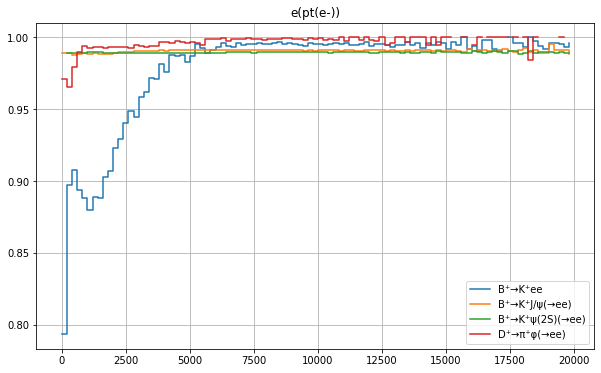

<ipython-input-218-d68881c83718>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])
<ipython-input-218-d68881c83718>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])
<ipython-input-218-d68881c83718>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])


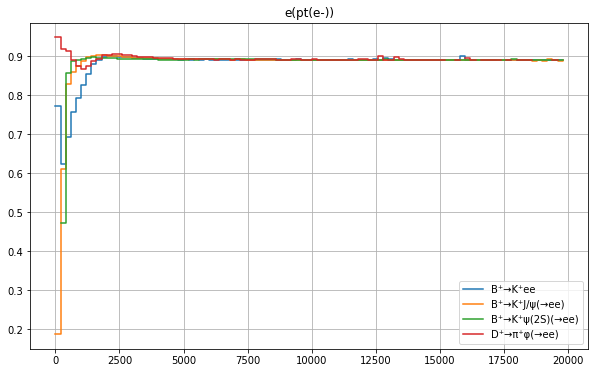

In [218]:
bins_ept = np.linspace(0,20000,101)
for label, idx in mapping_q2.items():
    d = X_q2[Y_q2==label]
    wd = 1-fn_la(d[:,0:2])
    ept = d[:,3]
    h1 = np.histogram(ept, bins=bins_ept)[0]
    hw = np.histogram(ept, bins=bins_ept, weights=wd)[0]
    plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])
plt.grid()
plt.title("e(pt(e-))")
plt.legend()
plt.show()
for label, idx in mapping_q2.items():
    d = X_q2[Y_q2==label]
    wd = 1-fn_ptpt(d[:,3:5])
    ept = d[:,3]
    h1 = np.histogram(ept, bins=bins_ept)[0]
    hw = np.histogram(ept, bins=bins_ept, weights=wd)[0]
    plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])
plt.grid()
plt.title("e(pt(e-))")
plt.legend()
plt.show()

In [203]:
truthed_B = [f.arrays(features + ["B_plus_TRUEPT"], sel, aliases=aliases, library="np") for f, sel in zip(raw_files[:3], selectors)]

<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log


<ipython-input-204-2e71cfd5fe93>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_B[:-1], hw/h1, where='post', label=df_index[idx])
<ipython-input-204-2e71cfd5fe93>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_B[:-1], hw/h1, where='post', label=df_index[idx])
<ipython-input-204-2e71cfd5fe93>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_B[:-1], hw/h1, where='post', label=df_index[idx])


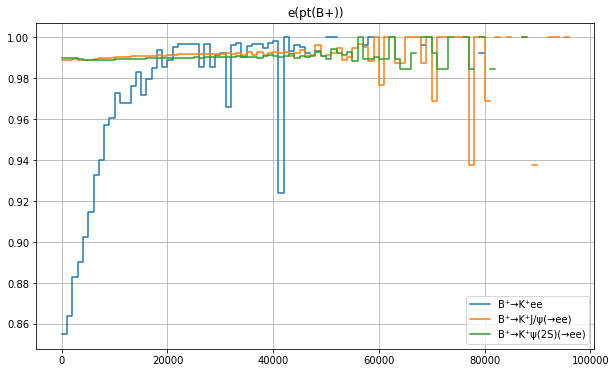

In [204]:
bins_B = np.linspace(0,100000,101)
for label, idx in enumerate([0,1,2]):
    d = np.hstack([truthed_B[idx][fn].reshape(-1, 1) for fn in ["alpha", "log_max_pl", "B_plus_TRUEPT"]])
    wd = 1-fn_la(d[:,0:2])
    Bpt = d[:,2]
    h1 = np.histogram(Bpt, bins=bins_B)[0]
    hw = np.histogram(Bpt, bins=bins_B, weights=wd)[0]
    plt.step(bins_B[:-1], hw/h1, where='post', label=df_index[idx])
plt.grid()
plt.title("e(pt(B+))")
plt.legend()
plt.show()

In [205]:
truthed_D = [f.arrays(features + ["D_plus_TRUEPT"], sel, aliases=aliases, library="np") for f, sel in zip(raw_files[3:], selectors[3:])]

<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log


<ipython-input-207-5c0faefd3a2c>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_D[:-1], hw/h1, where='post', label=df_index[idx])


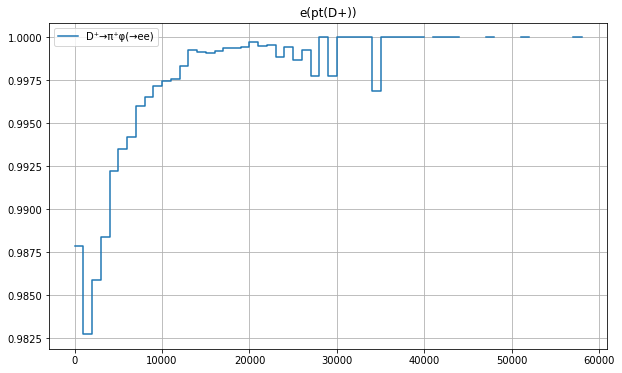

In [207]:
bins_D = np.linspace(0,100000,101)
for label, idx in enumerate([3]):
    d = np.hstack([truthed_D[idx-3][fn].reshape(-1, 1) for fn in ["alpha", "log_max_pl", "D_plus_TRUEPT"]])
    wd = 1-fn_la(d[:,0:2])
    Dpt = d[:,2]
    h1 = np.histogram(Dpt, bins=bins_D)[0]
    hw = np.histogram(Dpt, bins=bins_D, weights=wd)[0]
    plt.step(bins_D[:-1], hw/h1, where='post', label=df_index[idx])
plt.grid()
plt.title("e(pt(D+))")
plt.legend()
plt.show()